In [1]:
!pip install xgboost
!pip install shap
!pip install explainerdashboard
!pip install --upgrade fairlearn==0.7.0 raiwidgets

# Dateset:
- https://www.kaggle.com/saniyajaswani/credit-card-data

In [2]:
# import all modules
from pathlib import Path
from google.colab import drive

import pandas as pd #we use this to load, read and transform the dataset
import numpy as np #we use this for statistical analysis
import matplotlib.pyplot as plt #we use this to visualize the dataset
import seaborn as sns #we use this to make countplots

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder # scale numeric features
from sklearn.model_selection import train_test_split # train test split data

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics

import shap

from explainerdashboard import RegressionExplainer, ExplainerDashboard

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from fairlearn.metrics import selection_rate, MetricFrame
from fairlearn.reductions import GridSearch, EqualizedOdds, FalsePositiveRateParity, BoundedGroupLoss, ZeroOneLoss

#from raiwidgets import FairnessDashboard


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


In [3]:
# let´s mount the some folders for e.g. training data and models etc.
drive.mount('/content/gdrive')

# create data and model folders
MODELPATH = "gdrive/MyDrive/CLV_RAI/models"
DATAPATH = "gdrive/MyDrive/CLV_RAI/data"
IMAGEPATH = "gdrive/MyDrive/CLV_RAI/images"
DASHBOARDPATH = "gdrive/MyDrive/CLV_RAI/dashboard"

Path(MODELPATH).mkdir(parents=True, exist_ok=True)
Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(IMAGEPATH).mkdir(parents=True, exist_ok=True)
Path(DASHBOARDPATH).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df = pd.read_csv(DATAPATH / Path('cltv_bank.csv'))
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [5]:
# is the customer id unique?
print('df got {} datasets'.format(df.shape[0]))
print('df got {} unique customers'.format(df.Customer.unique().shape[0]))

df got 9134 datasets
df got 9134 unique customers


In [6]:
# check missing values
df.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [7]:
# what type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

# Define Feature Types and Target

In [8]:
target = ['Customer Lifetime Value']

numeric_features = ['Income', 
                    'Monthly Premium Auto', 
                    'Months Since Last Claim', 
                    'Months Since Policy Inception', 
                    'Number of Open Complaints', 
                    'Number of Policies', 
                    'Total Claim Amount']

cat_features = ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 
                'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size',
                'Gender', 'Marital Status', 'Location Code']

sensitive_features = ['Gender'] # we try to avoid any unfair model behavior along gender, marital status or location code

In [9]:
# reorder columns
df = df[numeric_features + cat_features + target]


In [10]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,7645.861827
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,2813.692575


# Let´s artificially introduce a gender bias

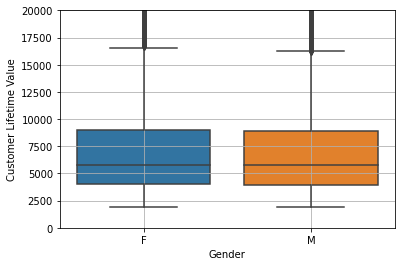

In [11]:
sns.boxplot(x='Gender', y='Customer Lifetime Value', data=df)
plt.grid('on')
plt.ylim(0,20000)
plt.show()

In [12]:
df.groupby(by='Gender').mean()['Customer Lifetime Value']

Gender
F    8096.602370
M    7909.551488
Name: Customer Lifetime Value, dtype: float64

In [13]:
df.groupby(by='Gender').std()['Customer Lifetime Value']

Gender
F    6956.059575
M    6780.743219
Name: Customer Lifetime Value, dtype: float64

In [14]:
# Let´s introduce the gender bias in terms that the customer life time value is clear less predictable for men than for women;
# in order to realize that, we add artificial normal noise to the men´s CLVs keeping the mean value unaffected

In [15]:
df.shape

(9134, 22)

In [16]:
df.loc[df['Gender']=='M'].shape[0]

4476

In [17]:
# let´s generate the noise
mean = 0
std = 2000
len = df.loc[df['Gender']=='M'].shape[0]
noise_array = np.random.normal(mean, std, len)
noise_array

array([ 2878.41121049,   459.58717856,  2114.82036355, ...,
       -1530.30678981, -2465.4478145 ,  1728.979371  ])

In [18]:
# let´s add the noise
df.loc[df['Gender']=='M', 'Customer Lifetime Value'] = df.loc[df['Gender']=='M', 'Customer Lifetime Value'] + noise_array

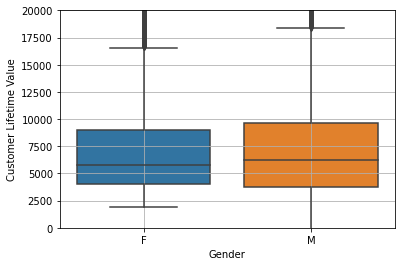

In [19]:
sns.boxplot(x='Gender', y='Customer Lifetime Value', data=df)
plt.grid('on')
plt.ylim(0,20000)
plt.show()

In [20]:
df.groupby(by='Gender').mean()['Customer Lifetime Value']

Gender
F    8096.602370
M    7859.303316
Name: Customer Lifetime Value, dtype: float64

In [21]:
df.groupby(by='Gender').std()['Customer Lifetime Value']

Gender
F    6956.059575
M    7059.992419
Name: Customer Lifetime Value, dtype: float64

# Lets do EDA on numeric features first

In [22]:
df[numeric_features].head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,56274,69,32,5,0,1,384.811147
1,0,94,13,42,0,8,1131.464935
2,48767,108,18,38,0,2,566.472247
3,0,106,18,65,0,7,529.881344
4,43836,73,12,44,0,1,138.130879


In [23]:
# descriptive statistics for numeric data
df.describe()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Customer Lifetime Value
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,7980.317000
std,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,7007.803517
min,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,-4466.114788
25%,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,3849.914405
50%,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,5992.783624
75%,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,9327.723808
max,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,83399.682160


In [24]:
# what about pearson correlation?
df[target + numeric_features].corr()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
Customer Lifetime Value,1.000000,0.022656,0.390436,0.010517,0.010368,-0.039152,0.022147,0.222691
Income,0.022656,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
Monthly Premium Auto,0.390436,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
Months Since Last Claim,0.010517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
Months Since Policy Inception,0.010368,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
Number of Open Complaints,-0.039152,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
Number of Policies,0.022147,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
Total Claim Amount,0.222691,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


Apparently we see some noticeable correlation between CLV, monthly premium auto and total claim amount

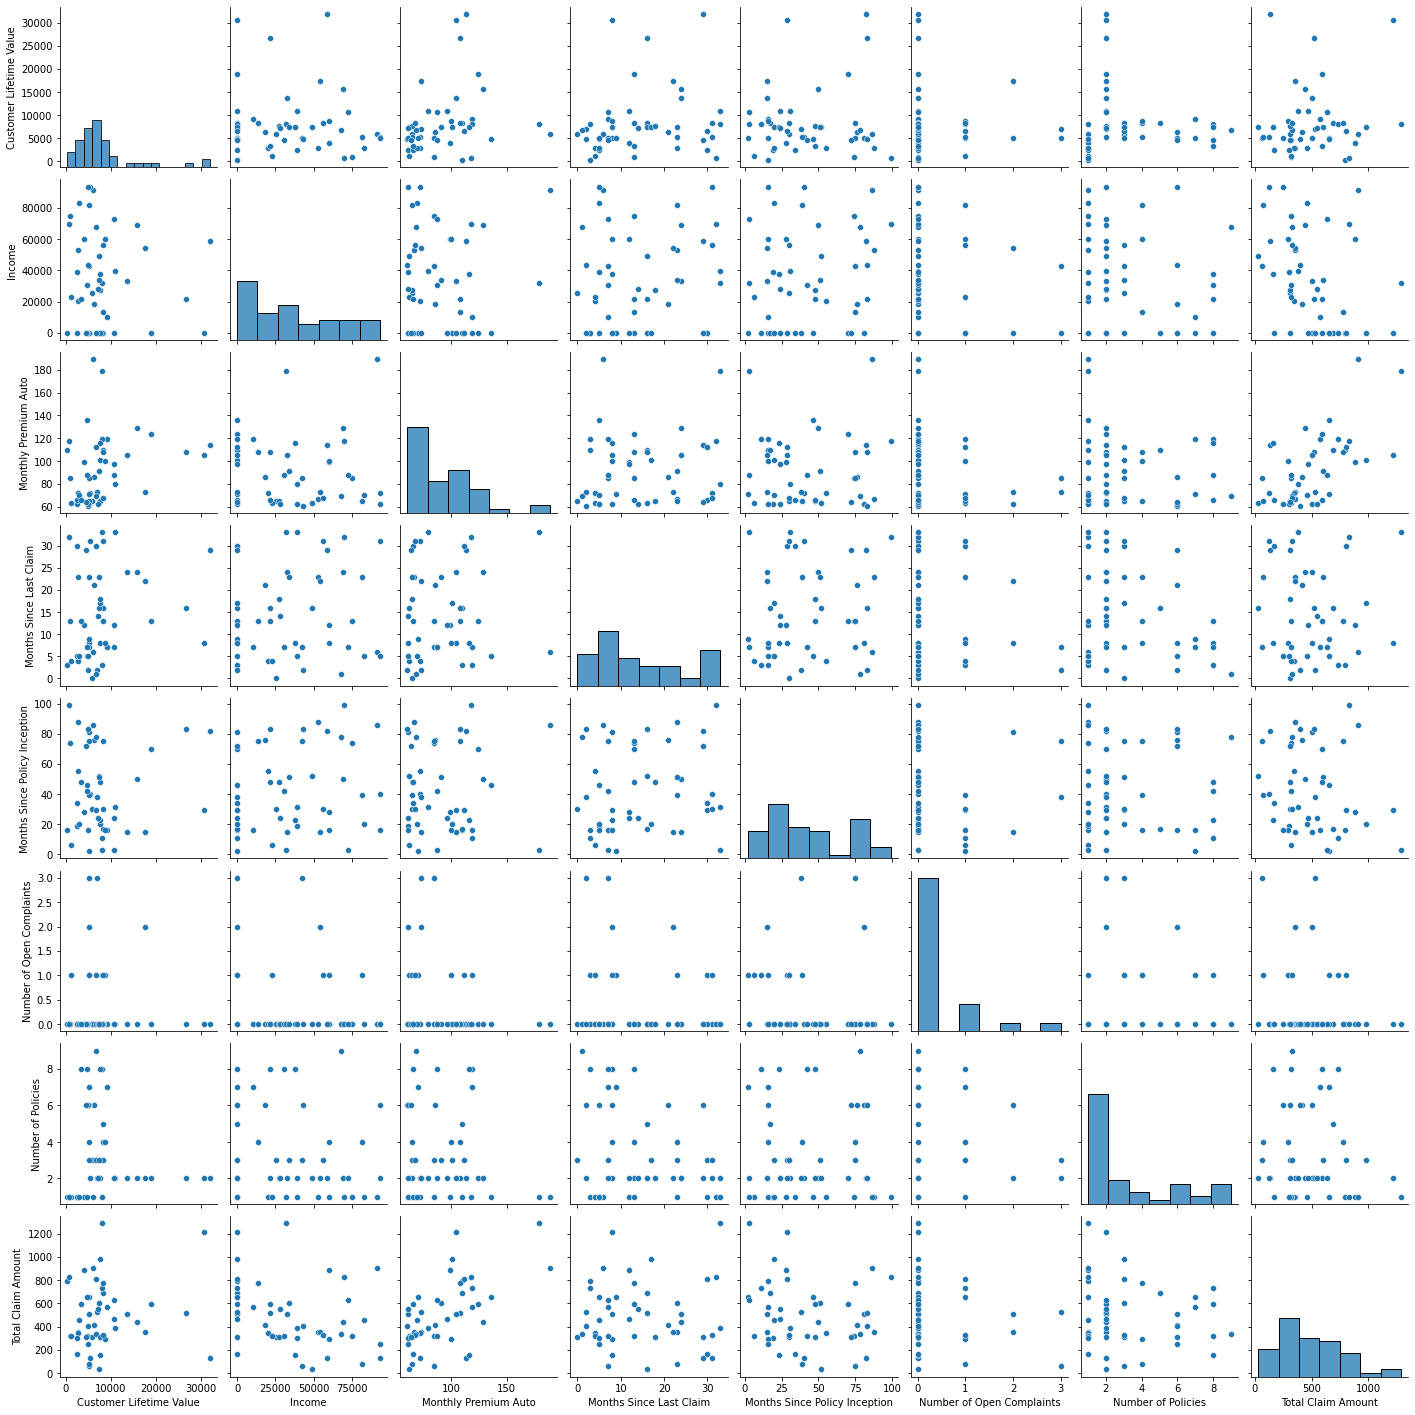

In [25]:
# lets have a look
sns.pairplot(df[target + numeric_features].sample(50))
plt.show()

so far, the chances are pretty low that we get some good CLV prediction by using the weakly correlated numeric data only (which I was hoping :-) )
so let´s go about the categorical data and hope for something good to happen ;-)

# Lets do EDA on categorical features

In [26]:
df[target + cat_features].head()

,Customer Lifetime Value,State,Response,Coverage,Education,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
0,2763.519279,Washington,No,Basic,Bachelor,Employed,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban
1,6979.535903,Arizona,No,Extended,Bachelor,Unemployed,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban
2,12887.431650,Nevada,No,Premium,Bachelor,Employed,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban
3,10524.273037,California,No,Basic,Bachelor,Unemployed,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban
4,3273.279754,Washington,No,Basic,Bachelor,Employed,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural


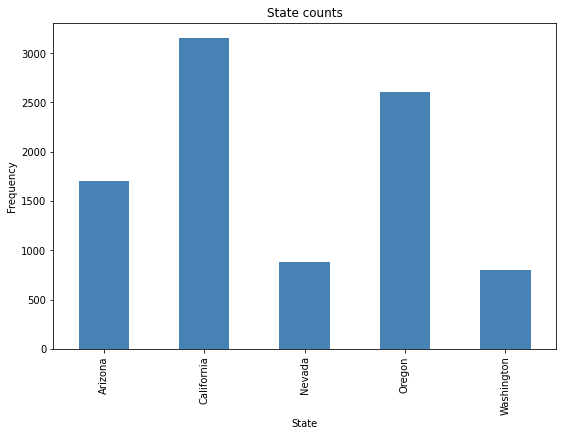

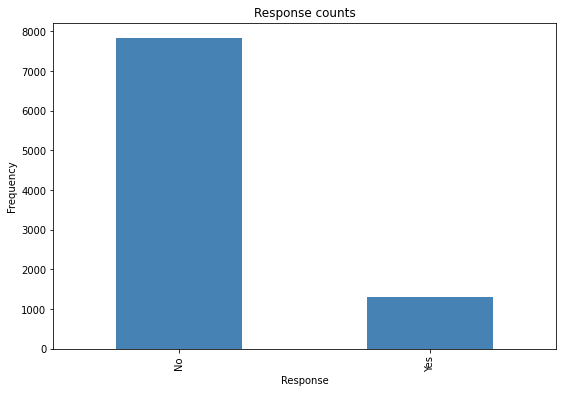

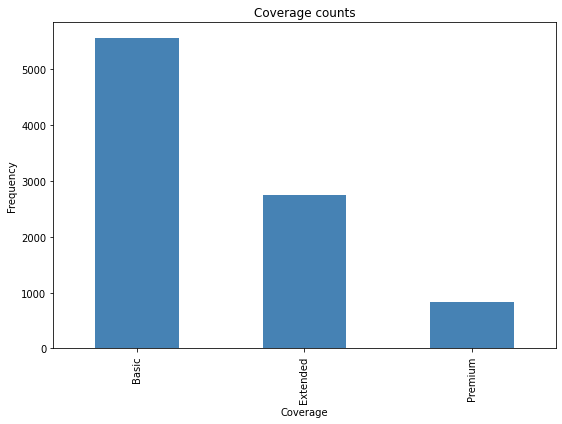

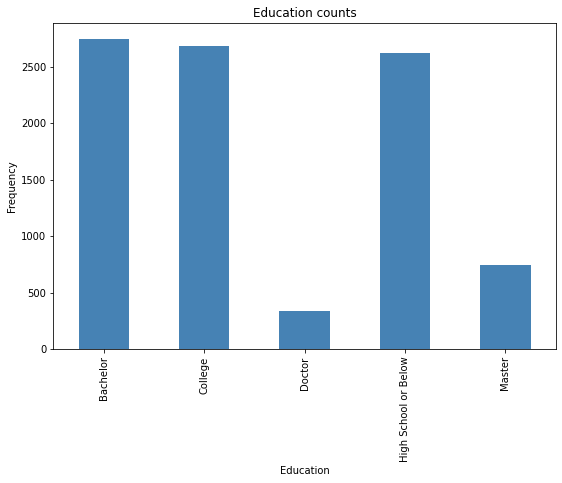

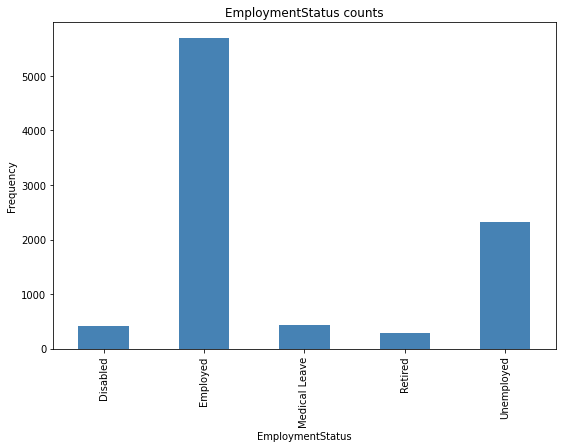

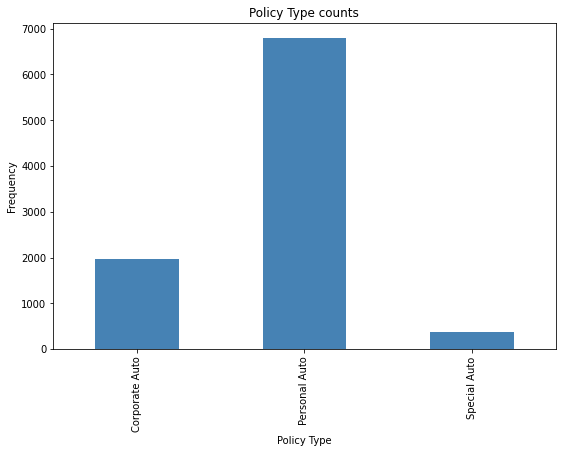

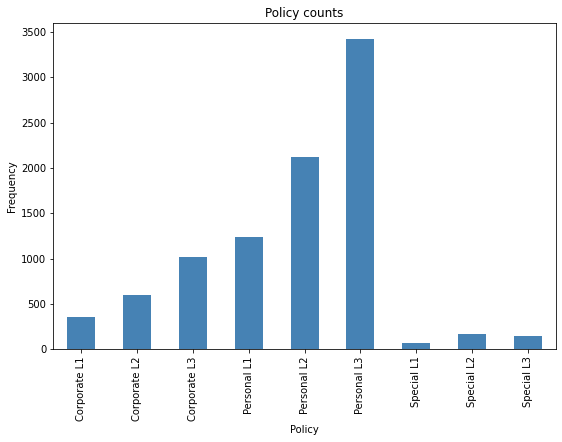

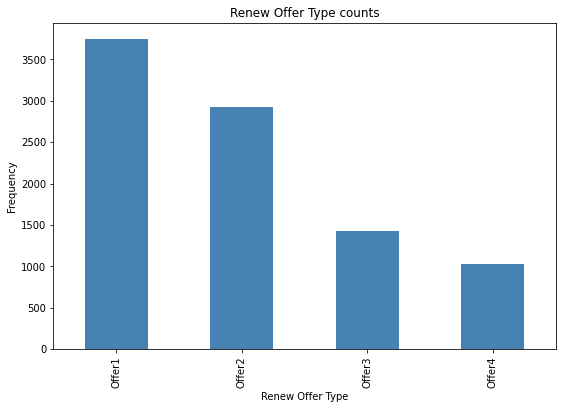

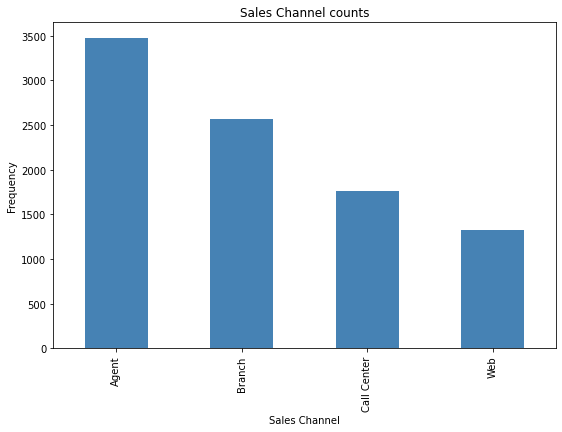

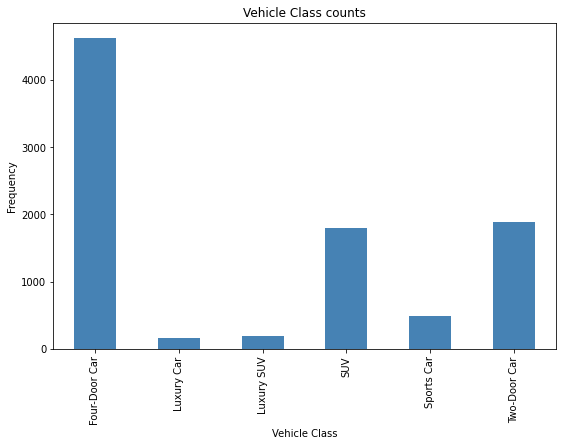

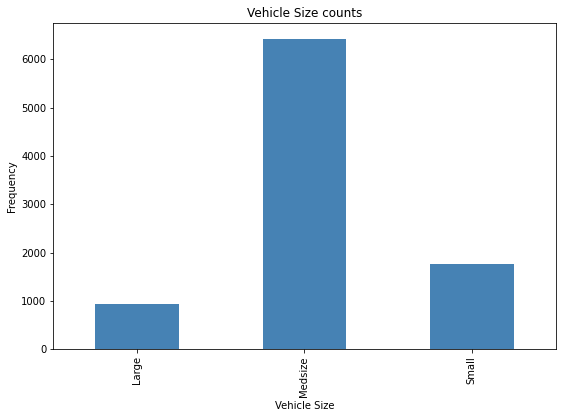

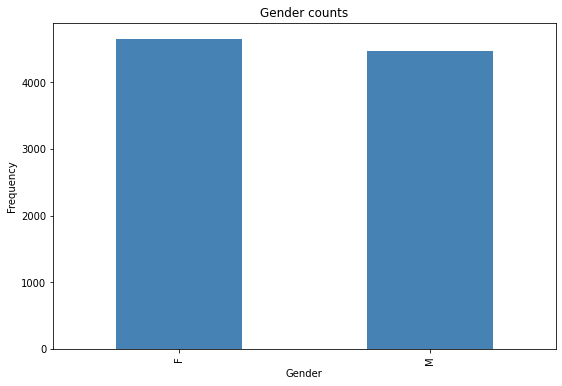

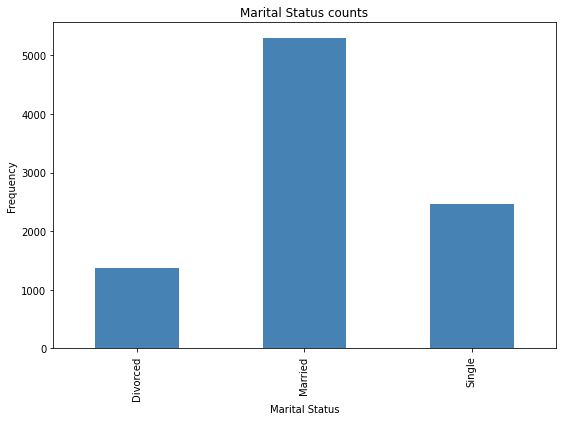

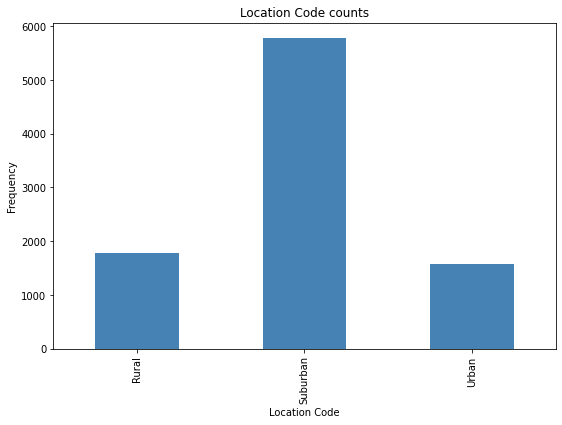

In [27]:
# plot a bar plot for each categorical feature count
for col in cat_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

With respect to the sensitive feature employment status, we dont want e.g. disabled people to be scored unfairly. With respect to the sensitive feature gender, we dont want male, female to be scored differently etc..

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


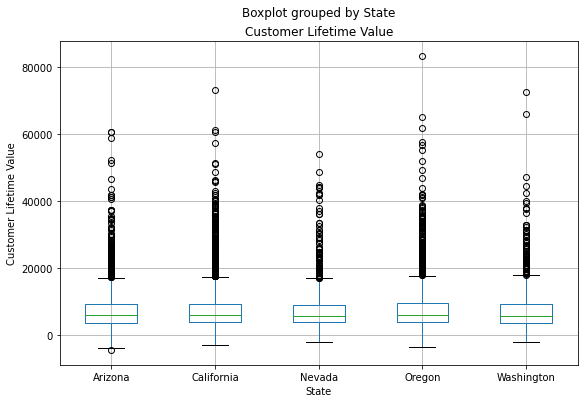

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


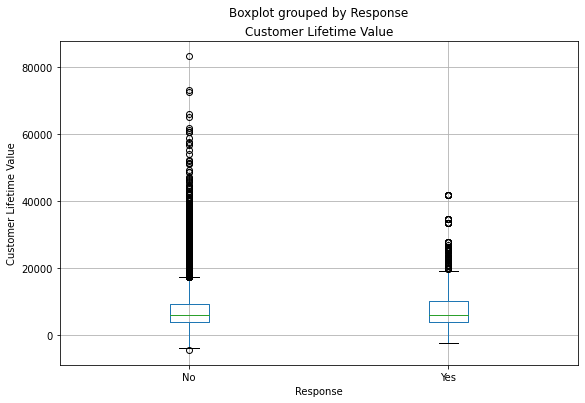

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


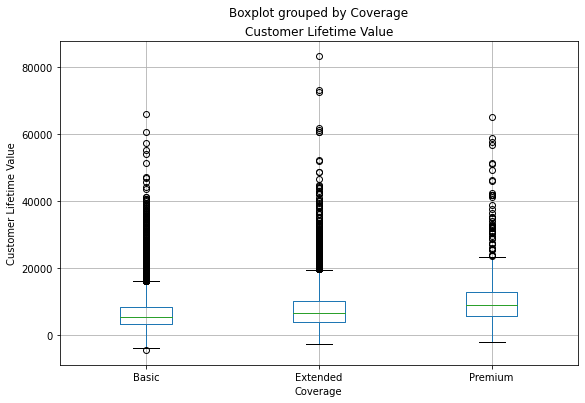

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


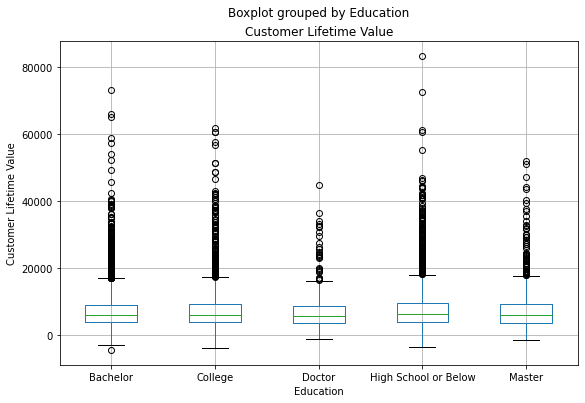

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


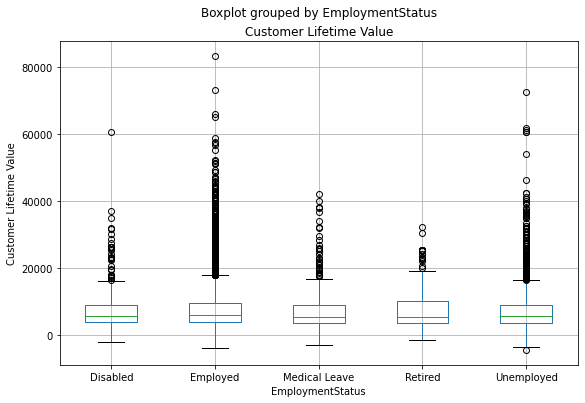

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


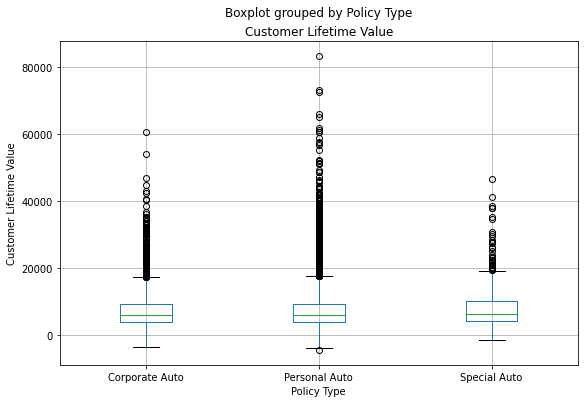

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


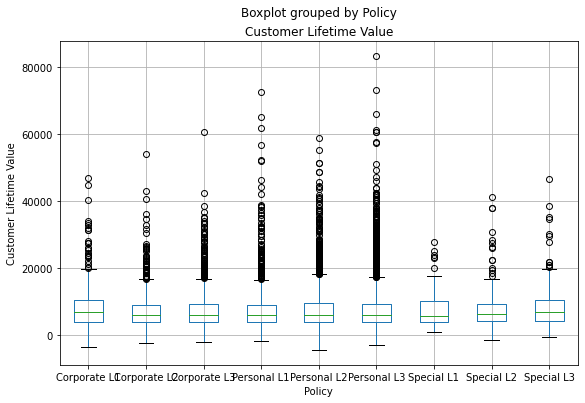

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


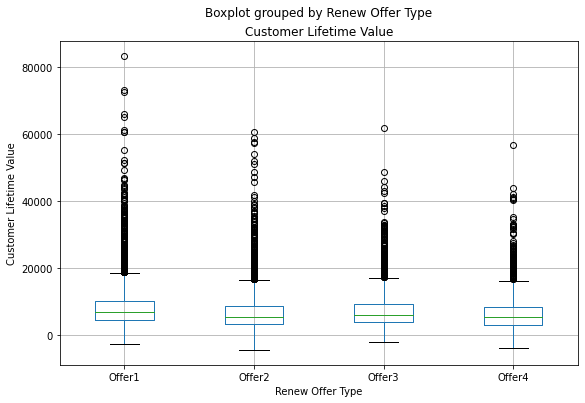

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


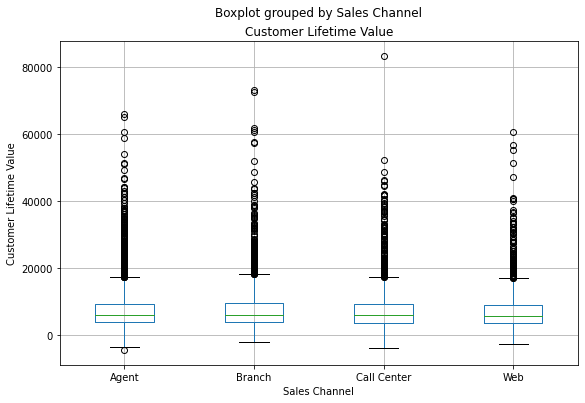

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


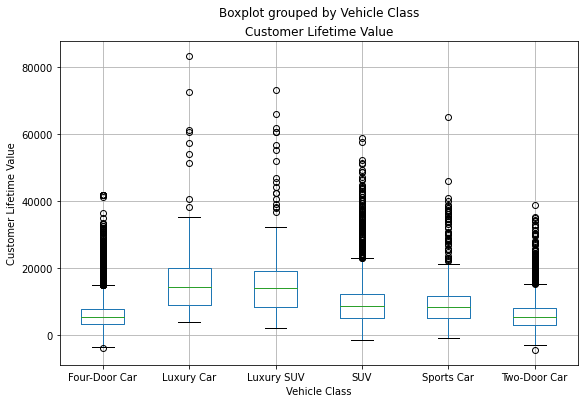

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


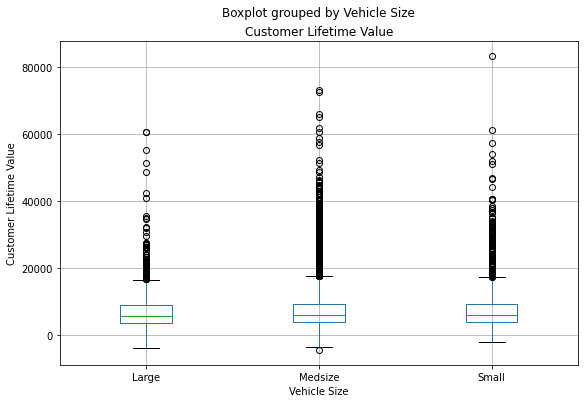

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


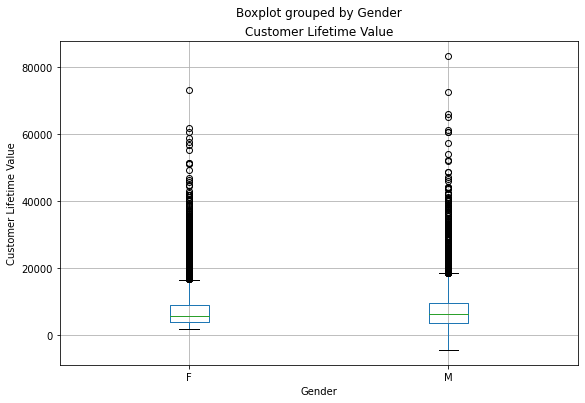

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


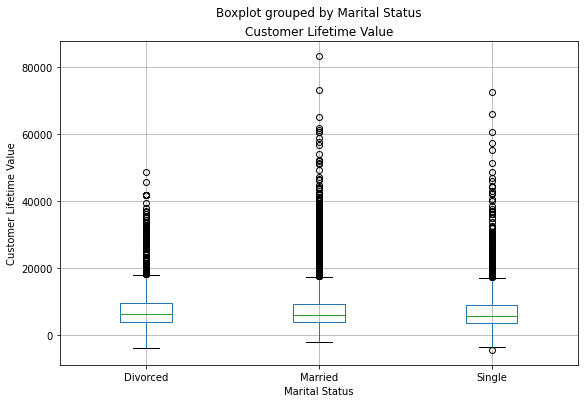

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


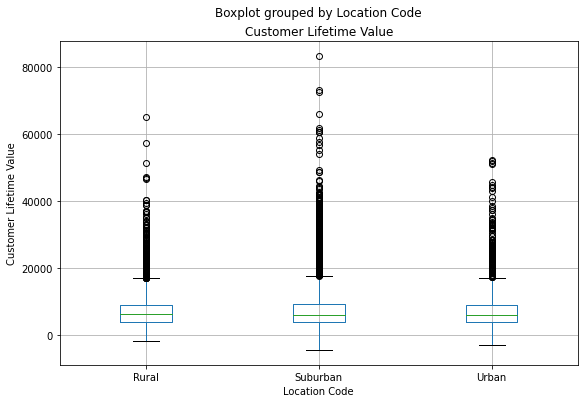

In [28]:
# plot a boxplot for the label by each categorical feature
for feat in cat_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column='Customer Lifetime Value', by = feat, ax = ax)
    ax.set_ylabel("Customer Lifetime Value")
    plt.show()

With respect to the features "coverage" and "vehicle class", we see some apparent effect on CLV.

# Train-Test Split

In [29]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,10524.273037
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,3273.279754


In [30]:
# Separate features and labels
X, y = df[numeric_features + cat_features], df[target].values
print('Features:',X[:3], '\nLabels:', y[:3], sep='\n')

Features:
   Income  Monthly Premium Auto  Months Since Last Claim  \
0   56274                    69                       32   
1       0                    94                       13   
2   48767                   108                       18   

   Months Since Policy Inception  Number of Open Complaints  \
0                              5                          0   
1                             42                          0   
2                             38                          0   

   Number of Policies  Total Claim Amount       State Response  Coverage  ...  \
0                   1          384.811147  Washington       No     Basic  ...   
1                   8         1131.464935     Arizona       No  Extended  ...   
2                   2          566.472247      Nevada       No   Premium  ...   

  EmploymentStatus     Policy Type        Policy Renew Offer Type  \
0         Employed  Corporate Auto  Corporate L3           Offer1   
1       Unemployed   Personal Aut

In [31]:
# Split data into training set and test set
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.40, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 5480 rows
Test Set: 3654 rows


## Scale Numeric Data

In [32]:
# scale numeric features
scaler = RobustScaler(quantile_range=(10,90))
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_train.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
925,-0.094889,0.484848,-0.142857,-0.233766,0.0,0.166667,0.252806,California,No,Basic,...,Employed,Corporate Auto,Corporate L3,Offer3,Web,SUV,Medsize,F,Married,Suburban
2830,0.796756,0.590909,-0.035714,0.610390,0.0,0.166667,-0.157252,Nevada,No,Extended,...,Employed,Personal Auto,Personal L3,Offer3,Call Center,SUV,Medsize,F,Married,Rural
3109,-0.289044,-0.227273,0.071429,0.103896,0.0,0.000000,-0.084312,Oregon,No,Basic,...,Retired,Personal Auto,Personal L3,Offer2,Branch,Four-Door Car,Small,F,Married,Suburban
3609,-0.206719,-0.303030,-0.250000,-0.038961,0.0,0.000000,-0.120175,Nevada,No,Basic,...,Disabled,Personal Auto,Personal L3,Offer2,Agent,Two-Door Car,Medsize,M,Married,Suburban
5570,0.060632,0.257576,0.714286,-0.311688,0.0,-0.166667,-0.315072,Oregon,No,Extended,...,Employed,Personal Auto,Personal L3,Offer3,Branch,Four-Door Car,Medsize,M,Married,Rural


# Label-Encoding Categorical Data


In [33]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [34]:
# init encoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
# fit encoder
enc.fit(X_train[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)

In [35]:
# transform data
X_train[cat_features] = enc.transform(X_train[cat_features])
X_train.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
925,-0.094889,0.484848,-0.142857,-0.233766,0.0,0.166667,0.252806,1.0,0.0,0.0,...,1.0,0.0,2.0,2.0,3.0,3.0,1.0,0.0,1.0,1.0
2830,0.796756,0.590909,-0.035714,0.610390,0.0,0.166667,-0.157252,2.0,0.0,1.0,...,1.0,1.0,5.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0
3109,-0.289044,-0.227273,0.071429,0.103896,0.0,0.000000,-0.084312,3.0,0.0,0.0,...,3.0,1.0,5.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0
3609,-0.206719,-0.303030,-0.250000,-0.038961,0.0,0.000000,-0.120175,2.0,0.0,0.0,...,0.0,1.0,5.0,1.0,0.0,5.0,1.0,1.0,1.0,1.0
5570,0.060632,0.257576,0.714286,-0.311688,0.0,-0.166667,-0.315072,3.0,0.0,1.0,...,1.0,1.0,5.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0


# Transform Hold-Out Dataset

In [36]:
# scale numeric data
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
# transform data
X_test[cat_features] = enc.transform(X_test[cat_features])
X_test.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
2182,0.341792,-0.181818,-0.035714,-0.285714,0.0,0.500000,-0.062794,1.0,0.0,0.0,...,1.0,1.0,4.0,2.0,0.0,5.0,1.0,0.0,0.0,1.0
7823,-0.414707,-0.212121,-0.142857,0.428571,0.0,-0.166667,0.166734,3.0,0.0,0.0,...,4.0,0.0,1.0,0.0,2.0,5.0,1.0,0.0,2.0,1.0
1651,0.233864,0.560606,-0.357143,-0.532468,0.0,0.666667,0.288670,4.0,0.0,2.0,...,1.0,1.0,5.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0
888,-0.078101,2.378788,-0.500000,0.311688,2.0,-0.166667,3.758537,0.0,0.0,1.0,...,2.0,1.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
3844,-0.414707,0.666667,0.035714,-0.038961,0.0,-0.166667,0.790761,4.0,0.0,1.0,...,4.0,1.0,3.0,3.0,0.0,3.0,2.0,1.0,2.0,1.0


# Model Selection: LightGBM vs Boosted Tree

In [37]:
lgb_model = LGBMRegressor().fit(X_train, y_train.reshape(-1))
print (lgb_model)

LGBMRegressor()


MSE: 17046583.071121845
RMSE: 4128.750788207232
R2: 0.6584386373705295


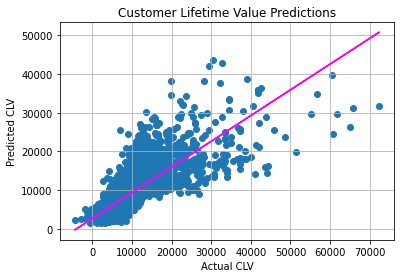

In [38]:
# Evaluate Model
predictions = lgb_model.predict(X_test).reshape(-1)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Lifetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

In [39]:
# Train XGB model
xgb_model = XGBRegressor().fit(X_train, y_train)
print (xgb_model)

[17:20:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor()


MSE: 17297732.635144074
RMSE: 4159.054295767738
R2: 0.6534063686188787


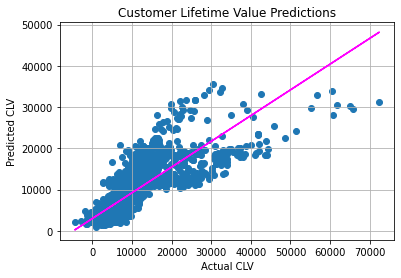

In [40]:
# Evaluate Model
predictions = xgb_model.predict(X_test).reshape(-1)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Lifetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()


# Tune Best Model

In [41]:
# tune these hyperparameters
params = {
 'num_leaves': [20, 30, 40],
 'n_estimators' : [50, 100, 200]
 }

In [42]:
# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(lgb_model, 
                          params, 
                          scoring=score, cv=3, 
                          return_train_score=True)
gridsearch.fit(X_train, y_train.reshape(-1))
print("Best parameter combination:", gridsearch.best_params_, "\n")

Best parameter combination: {'n_estimators': 50, 'num_leaves': 20} 



In [43]:
# get tuned model
tuned_model = gridsearch.best_estimator_
print(tuned_model, "\n")

LGBMRegressor(n_estimators=50, num_leaves=20) 



In [44]:
# Evaluate the model using the test data
predictions = tuned_model.predict(X_test).reshape(-1)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 16910542.499174826
RMSE: 4112.2430009880045
R2: 0.6611644741516165


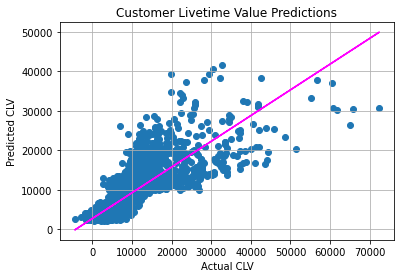

In [45]:
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Livetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

# Explain Model

In [46]:
print(tuned_model)

LGBMRegressor(n_estimators=50, num_leaves=20)


In [47]:
# get feature names
feature_names = list(X_train.columns)
# init Tree explainer
explainer = shap.TreeExplainer(tuned_model, X_test)
# get shapley values
shap_values = explainer(X_test, check_additivity=False)

## init Partition Explainer
#explainer = shap.PartitionExplainer(model.predict, X_test)
## get shapley values
#shap_values = explainer(X_test)

## Global Model Explanation

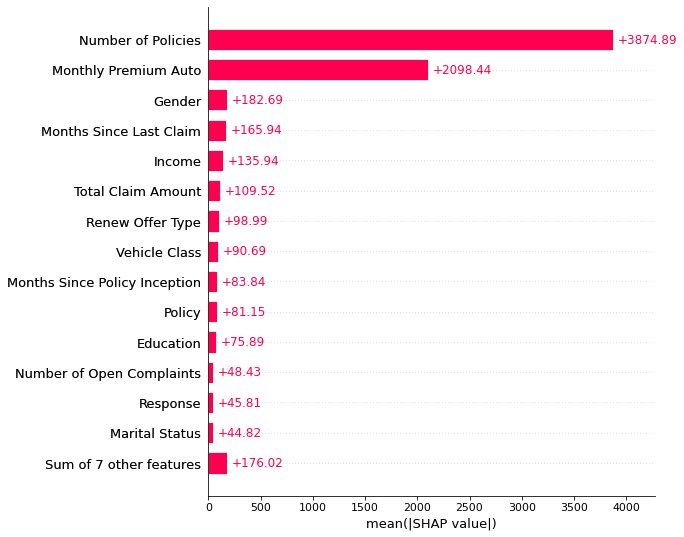

In [48]:
shap.plots.bar(shap_values, max_display=15)

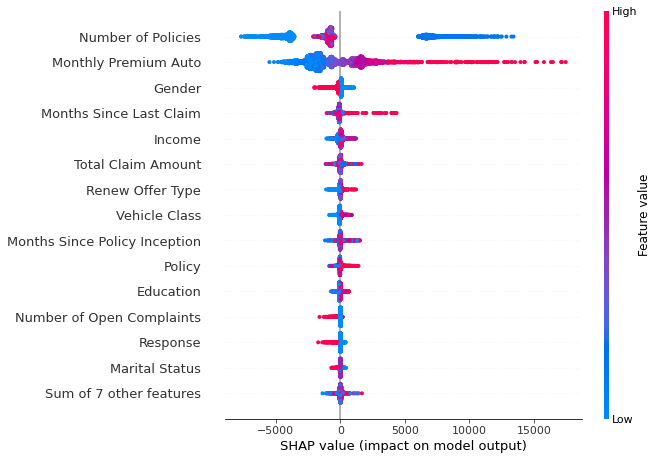

In [49]:
shap.plots.beeswarm(shap_values, max_display=15)

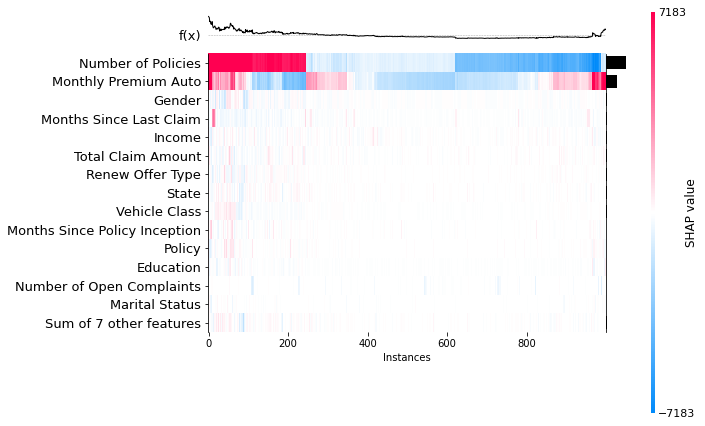

In [50]:
shap.plots.heatmap(shap_values[0:1000], max_display=15)

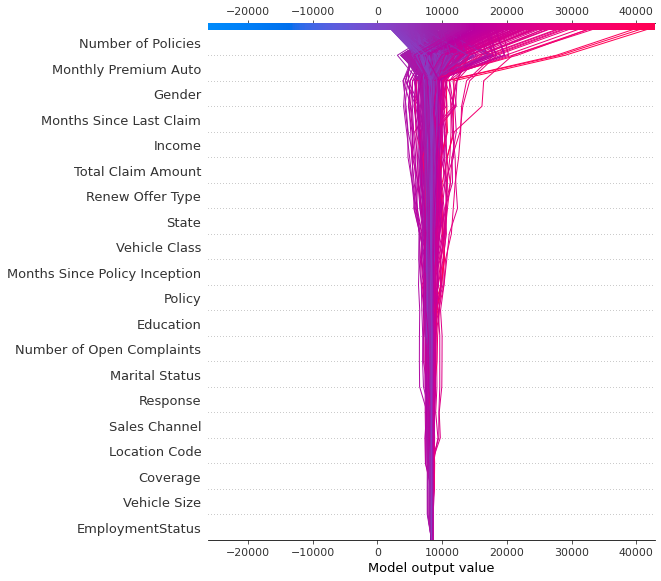

In [51]:
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.decision_plot(base_value=shap_values.base_values[0], 
                   shap_values= shap_values.values[0:1000],
                   features = X_test_invtrans[0:1000],
                   ignore_warnings=True)

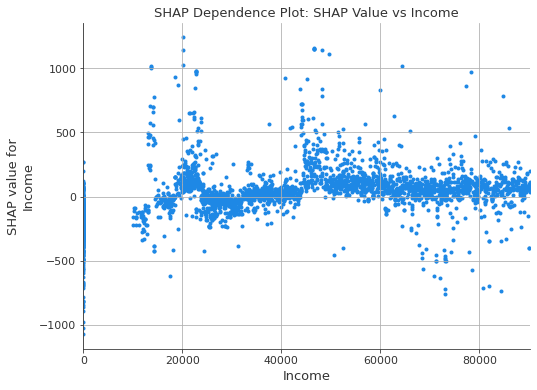

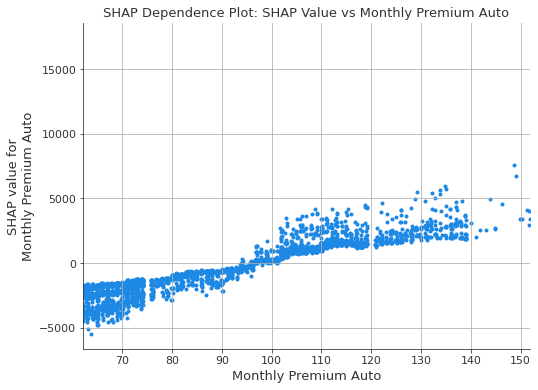

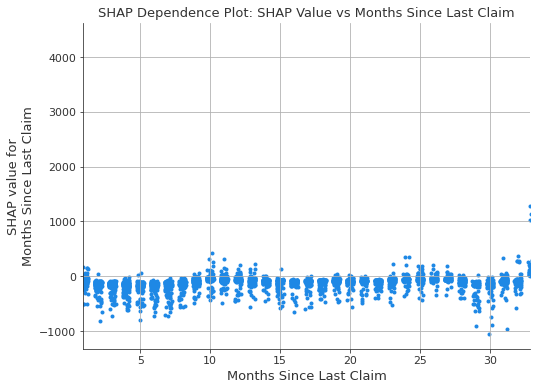

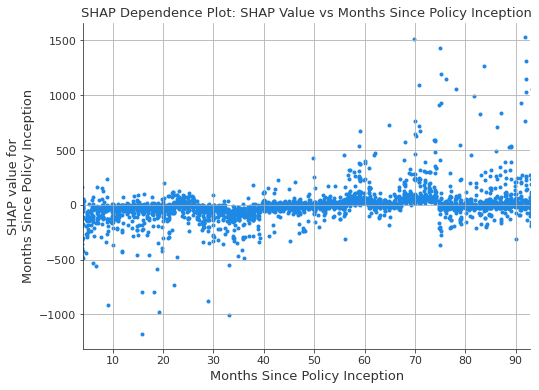

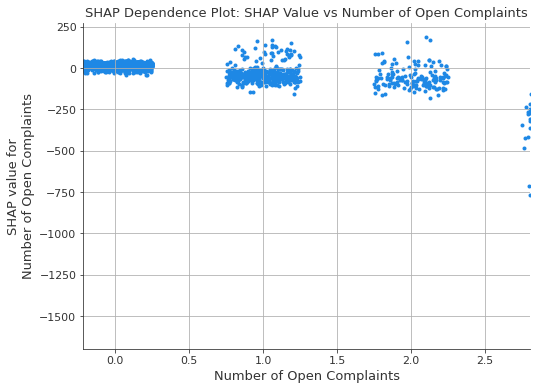

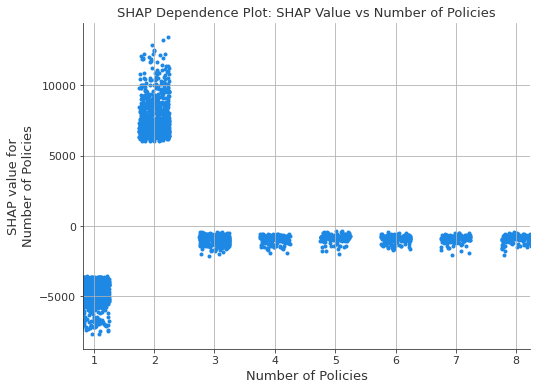

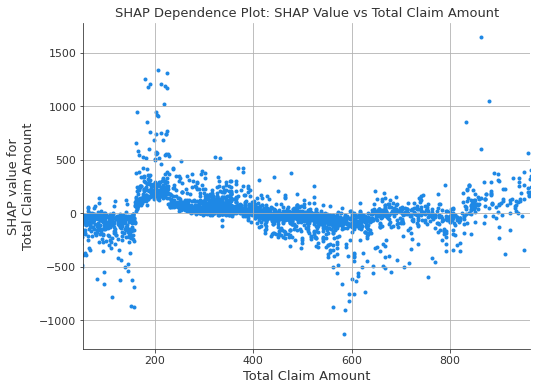

In [52]:
# show shap dependence plot for numeric features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for nf in numeric_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(nf, 
                      shap_values = shap_values.values, 
                      features = X_test_invtrans,
                      x_jitter = 0.5,
                      xmin="percentile(5.0)",
                      xmax="percentile(95.0)", 
                      interaction_index=None,
                      title = 'SHAP Dependence Plot: SHAP Value vs {}'.format(nf),
                      ax=ax,
                      show=False)
  ax.grid('on')

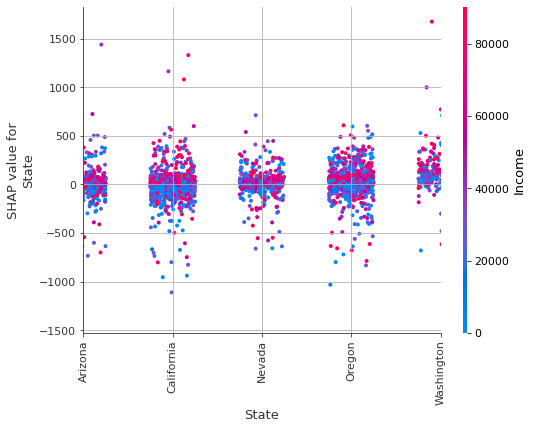

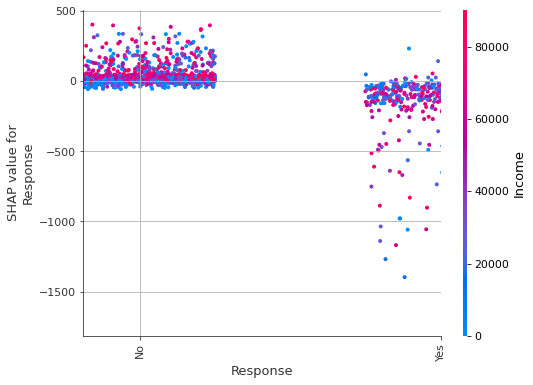

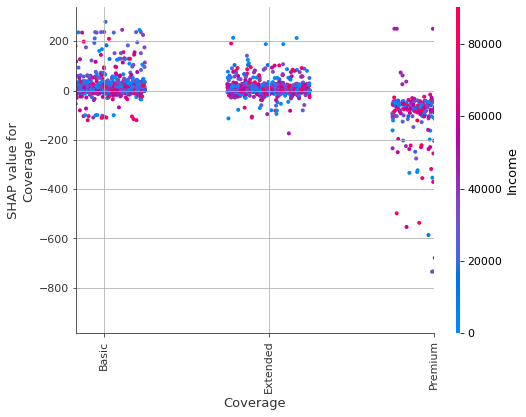

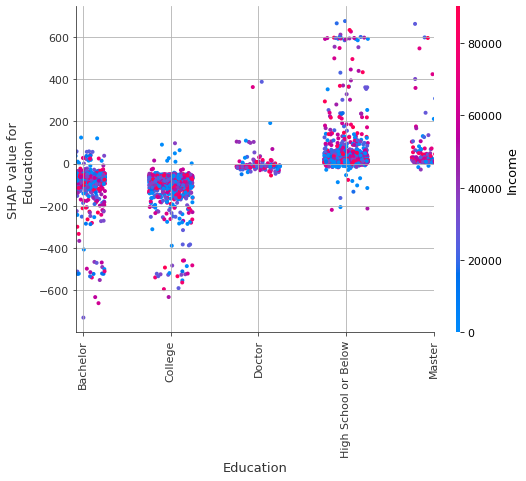

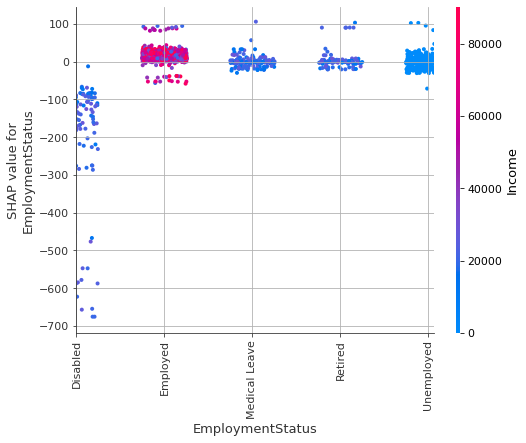

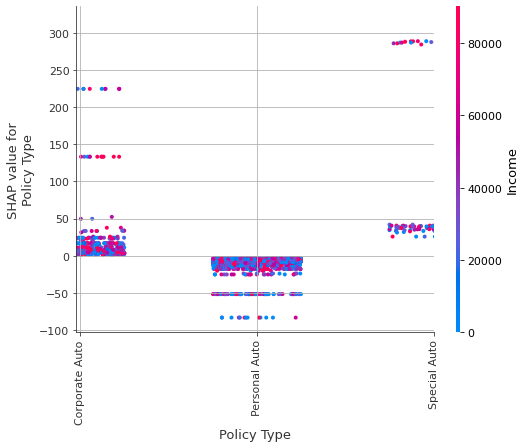

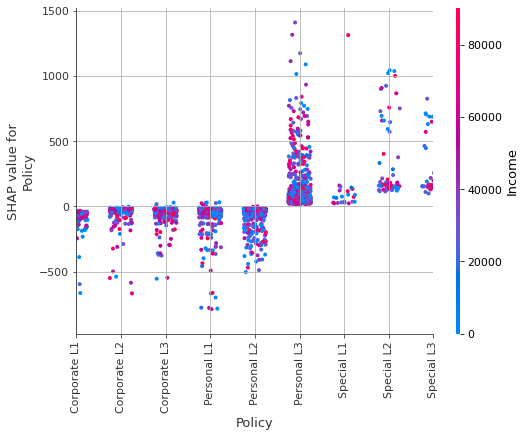

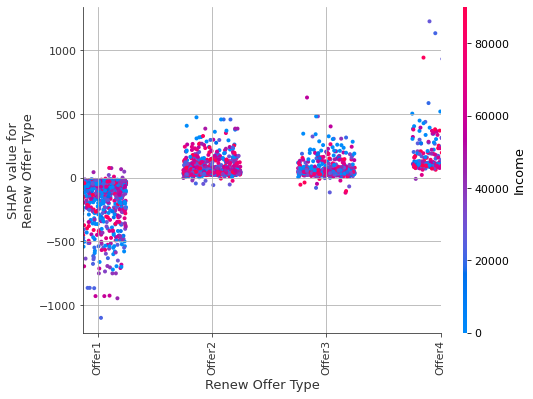

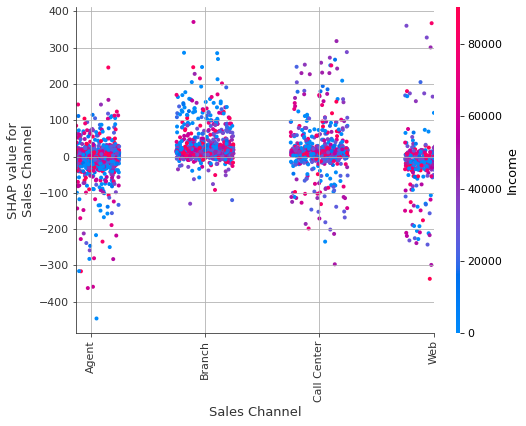

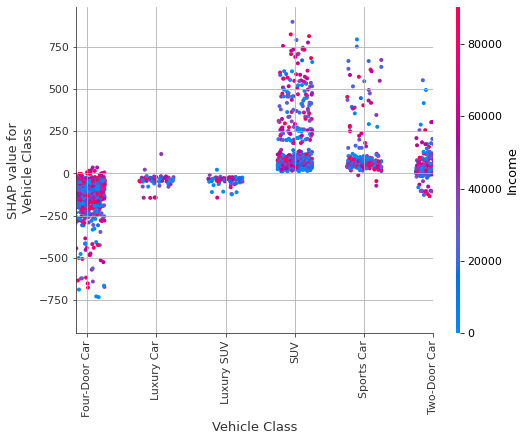

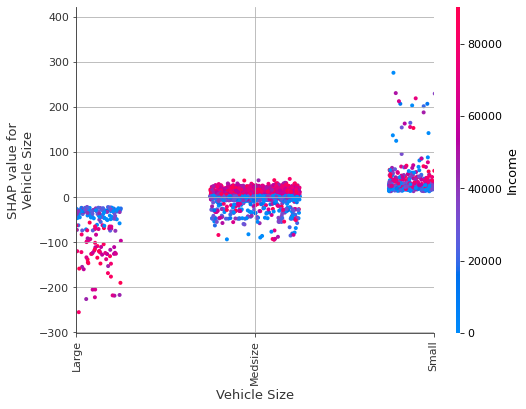

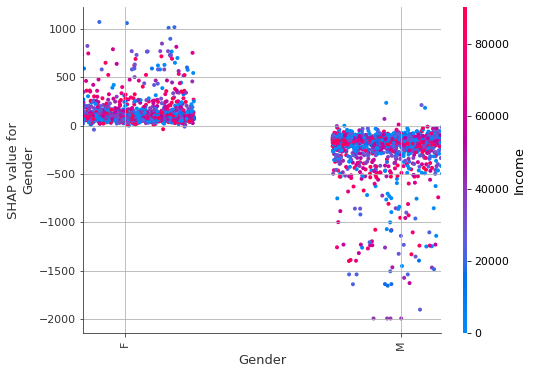

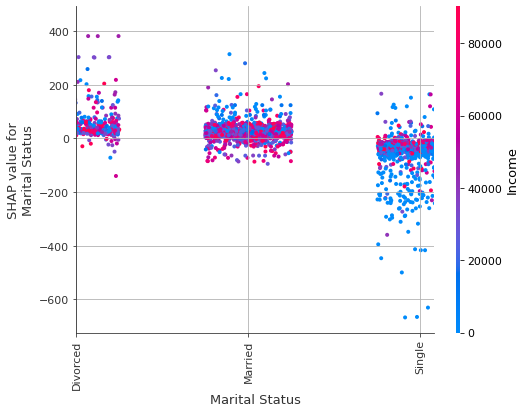

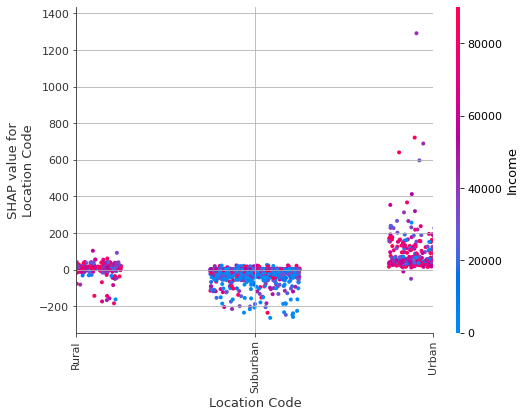

In [53]:
# show shap dependence plot for categorical features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for cf in cat_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(cf, 
                       shap_values = shap_values.values, 
                       features = X_test_invtrans,
                       x_jitter = .5,
                       xmin="percentile(10.0)",
                       xmax="percentile(90.0)", 
                       interaction_index='Income',
                       ax=ax,
                       show=False)
  ax.grid('on')

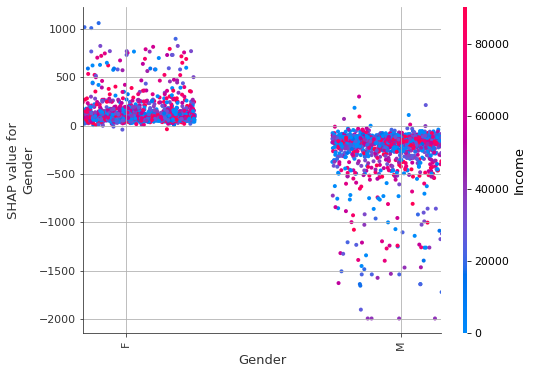

In [54]:
# show shap dependence plot for sensitive (categorical) features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for sf in sensitive_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(sf, 
                       shap_values = shap_values.values, 
                       features = X_test_invtrans,
                       x_jitter = .5,
                       xmin="percentile(10.0)",
                       xmax="percentile(90.0)", 
                       interaction_index='Income',
                       ax=ax,
                       show=False)
  ax.grid('on')

## Local Model Explanation

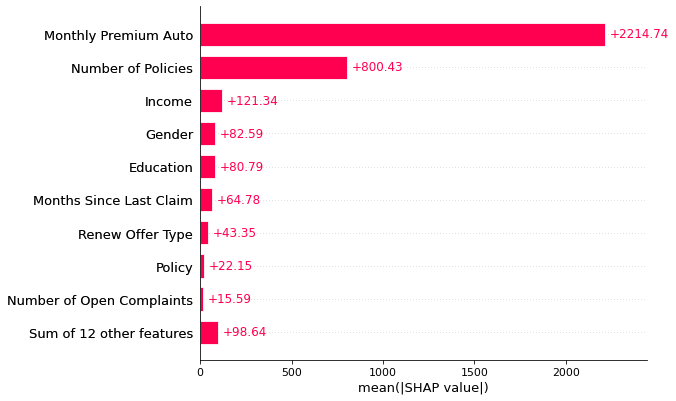

In [55]:
shap.plots.bar(shap_values[0:1])

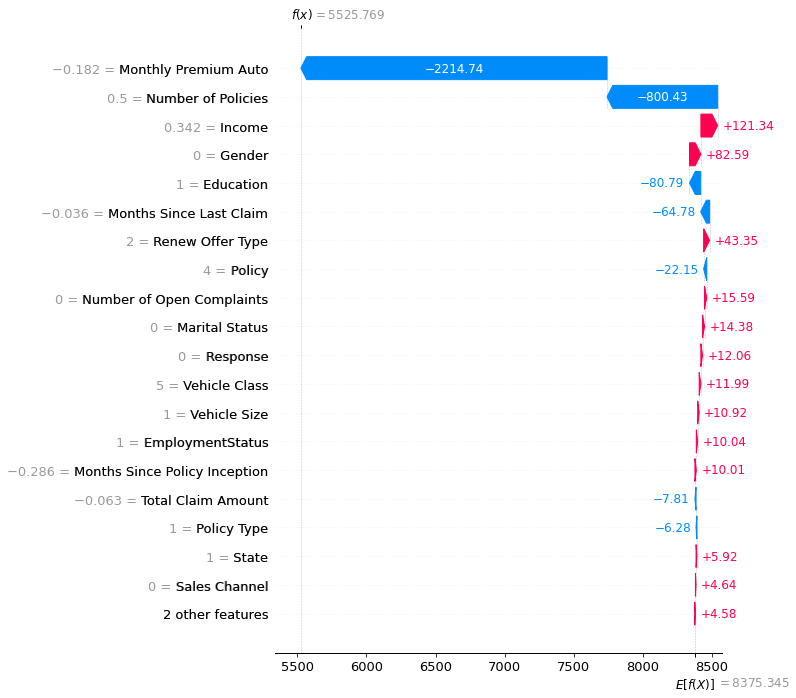

In [56]:
shap.plots.waterfall(shap_values[0], max_display=20)

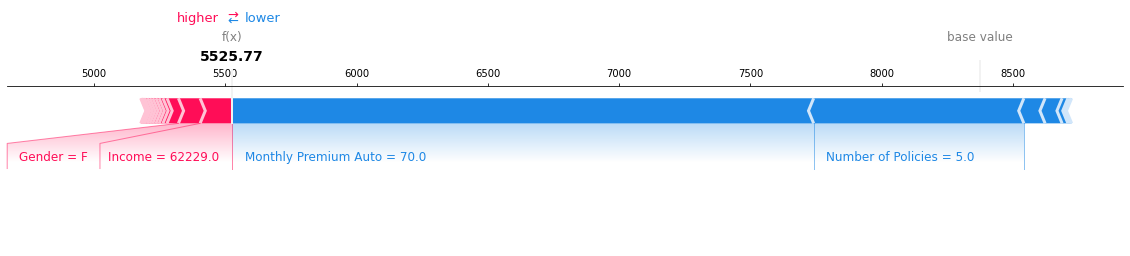

In [57]:
#shap.initjs()
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.force_plot(base_value=shap_values.base_values[0], 
                shap_values= shap_values.values[0:1],
                features = X_test_invtrans[0:1], 
                matplotlib=True)

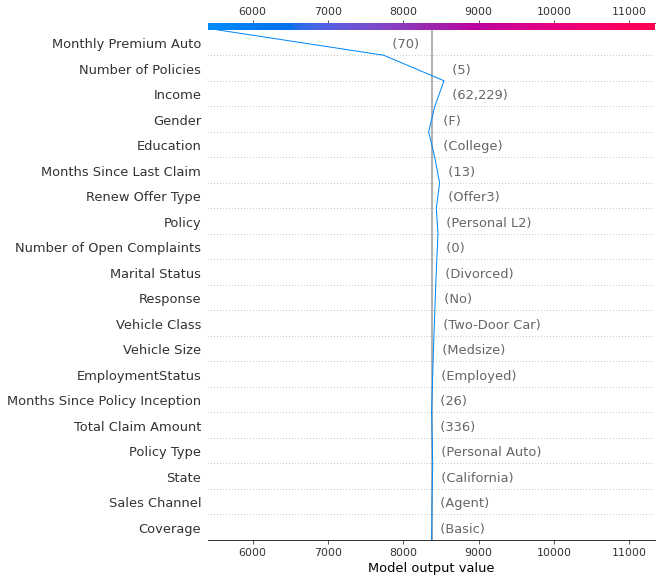

In [58]:
#shap.initjs()
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.decision_plot(base_value=shap_values.base_values[0], 
                shap_values= shap_values.values[0:1],
                features = X_test_invtrans[0:1])

# Model Explainer Dashboard

In [59]:
tuned_model

LGBMRegressor(n_estimators=50, num_leaves=20)

In [60]:
explainer = RegressionExplainer(tuned_model, 
                                X_test, y_test,
                                shap='tree',
                                X_background=shap.sample(X_test, 50), 
                                precision='float32',
                                n_jobs=-1)
db = ExplainerDashboard(explainer)

Generating self.shap_explainer = shap.TreeExplainer(model, X_background)
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [61]:
db.to_yaml(DASHBOARDPATH / Path('dashboard_regression.yaml'), 
           explainerfile=Path('explainer_regression.joblib'), 
           dump_explainer=True)

Dumping configuration .yaml to /content/gdrive/MyDrive/CLV_RAI/dashboard/dashboard_regression.yaml...
Dumping explainer to /content/gdrive/MyDrive/CLV_RAI/dashboard/explainer_regression.joblib...


In [62]:
# Run Dashboard
db = ExplainerDashboard.from_config(DASHBOARDPATH / Path('explainer_regression.joblib'), 
                                    DASHBOARDPATH /  Path('dashboard_regression.yaml'))
db.run(host='0.0.0.0', port=9050, use_waitress=True)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.2:9050
You can terminate the dashboard with ExplainerDashboard.terminate(9050)
Dash is running on http://127.0.0.1:9050/

Dash is running on http://127.0.0.1:9050/

Dash app running on:


<IPython.core.display.Javascript object>

# Make Inference Pipeline

[17:20:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(quantile_range=(10,
                                                                                                90)))]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array([ 7,  8,  9, 10, 11, 12, 13, 14,

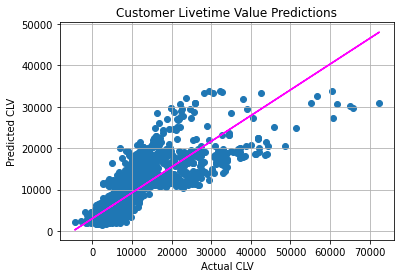

In [63]:
# Define preprocessing for numeric columns (scale them)
num_features = list(np.arange(0,7))
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler(quantile_range=(10,90)))])

# Define preprocessing for categorical features (encode them)
categorical_features = np.arange(7,X.shape[1])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=True, drop='first', handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor())])

model = pipeline.fit(X_train, y_train)
print(model)

# get predictions
predictions = model.predict(X_test)

# Evaluate the model using the test data
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Livetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

# Model Fairness

In [64]:
def r2_female(fairlearn_metricframe)->float:
  """ Returns r2 for the female group. """
  r2_female = group_metrics.by_group['R2'][0]  
  return r2_female

def r2_male(fairlearn_metricframe)->float:
  """ Returns r2 for the male group. """
  r2_male = group_metrics.by_group['R2'][1]  
  return r2_male  

def group_difference_r2(fairlearn_metricframe)->float:
  """ Returns the absolute r2 difference for the sensitive group. """
  r2_diff = np.abs(group_metrics.by_group['R2'][0] - group_metrics.by_group['R2'][1])  
  return r2_diff

In [65]:
# Get metrics by sensitive group from fairlearn
print('\nMetrics by Group:')
metrics = {'R2': r2_score,
           'MSE': mean_squared_error}

group_metrics = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=model.predict(X_test),
                             sensitive_features=X_test[sensitive_features])

print(group_metrics.by_group)


Metrics by Group:
              R2              MSE
Gender                           
0.0     0.698098  14529352.956822
1.0     0.611054  20151569.204918


In [66]:
# show r2 for females
r2_female(group_metrics)

0.698097892808315

In [67]:
# show r2 for males
r2_male(group_metrics)

0.6110535015782415

In [68]:
# show the r2 difference between men and women
group_difference_r2(group_metrics)

0.08704439123007357

In [69]:
## View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
#FairnessDashboard(sensitive_features=X_test[sensitive_features],
#                   y_true=y_test,
#                   y_pred={"CLV_model": model.predict(X_test)})

## Mitigate Unfairness in the Model

In [70]:
from fairlearn.reductions  import AbsoluteLoss, ExponentiatedGradient  

In [71]:
# Mitigate Selection Parity

print('Finding mitigated models...')

# Train multiple models
sweep = GridSearch(LGBMRegressor(),
                   constraints=BoundedGroupLoss(loss=ZeroOneLoss()),
                   grid_size=20)

sweep.fit(X_train, y_train, sensitive_features=X_train[sensitive_features])
models = sweep.predictors_

Finding mitigated models...


In [72]:
models

[LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor()]

In [73]:
models[0]

LGBMRegressor()

In [74]:
# show model fairness for all models
model_fairness = {}

# calculate group metric for the unmitigated model
group_metrics = MetricFrame(metrics=metrics,
                            y_true=y_test,
                            y_pred=tuned_model.predict(X_test),
                            sensitive_features=X_test[sensitive_features])

# get r2 for females
r2_f = r2_female(group_metrics)
# get r2 for males
r2_m = r2_male(group_metrics)
# show the r2 difference between men and women
r2_diff = group_difference_r2(group_metrics)

# track model performance and faireness
model_fairness['model_unmitigated'] = [r2_f, r2_m, r2_diff]


counter = 0
for model in models:
  counter += 1
  y_pred = model.predict(X_test)
  group_metrics = MetricFrame(metrics=metrics,
                              y_true=y_test,
                              y_pred=y_pred,
                              sensitive_features=X_test[sensitive_features])

  # get r2 for females
  r2_f = r2_female(group_metrics)
  # get r2 for males
  r2_m = r2_male(group_metrics)
  # show the r2 difference between men and women
  r2_diff = group_difference_r2(group_metrics)

  # track model performance and faireness
  model_fairness['model_mitigated #'+str(counter)] = [r2_f, r2_m, r2_diff] 


  print('---------------------------------------------\n')
  print('Model #', counter)
  print('Model Fairness Metrics: ')
  print(group_metrics.by_group)
  print(' R2 Difference Men vs Women: r2-diff={:.2f}'.format(r2_diff))
  print('---------------------------------------------\n')

---------------------------------------------

Model # 1
Model Fairness Metrics: 
              R2              MSE
Gender                           
0.0     0.619897  18292830.319025
1.0     0.601003   20672294.04133
 R2 Difference Men vs Women: r2-diff=0.02
---------------------------------------------

---------------------------------------------

Model # 2
Model Fairness Metrics: 
              R2              MSE
Gender                           
0.0     0.657295  16493031.882019
1.0     0.599141  20768737.799176
 R2 Difference Men vs Women: r2-diff=0.06
---------------------------------------------

---------------------------------------------

Model # 3
Model Fairness Metrics: 
              R2              MSE
Gender                           
0.0     0.680026  15399057.697999
1.0      0.59551  20956891.250971
 R2 Difference Men vs Women: r2-diff=0.08
---------------------------------------------

---------------------------------------------

Model # 4
Model Fairness Metrics

In [75]:
# transform fairness and performance dict to dataframe
df_fairness = pd.DataFrame(model_fairness, index=['r2_female', 'r2_male', 'r2_diff']).T
df_fairness.head()

,r2_female,r2_male,r2_diff
model_unmitigated,0.710954,0.611707,0.099247
model_mitigated #1,0.619897,0.601003,0.018894
model_mitigated #2,0.657295,0.599141,0.058154
model_mitigated #3,0.680026,0.595510,0.084517
model_mitigated #4,0.676108,0.600997,0.075111


In [76]:
# add r2 averaged over both groups
df_fairness['r2_group_average'] = 0.5*(df_fairness['r2_female'] + df_fairness['r2_male'])
df_fairness.head()

,r2_female,r2_male,r2_diff,r2_group_average
model_unmitigated,0.710954,0.611707,0.099247,0.661331
model_mitigated #1,0.619897,0.601003,0.018894,0.610450
model_mitigated #2,0.657295,0.599141,0.058154,0.628218
model_mitigated #3,0.680026,0.595510,0.084517,0.637768
model_mitigated #4,0.676108,0.600997,0.075111,0.638553


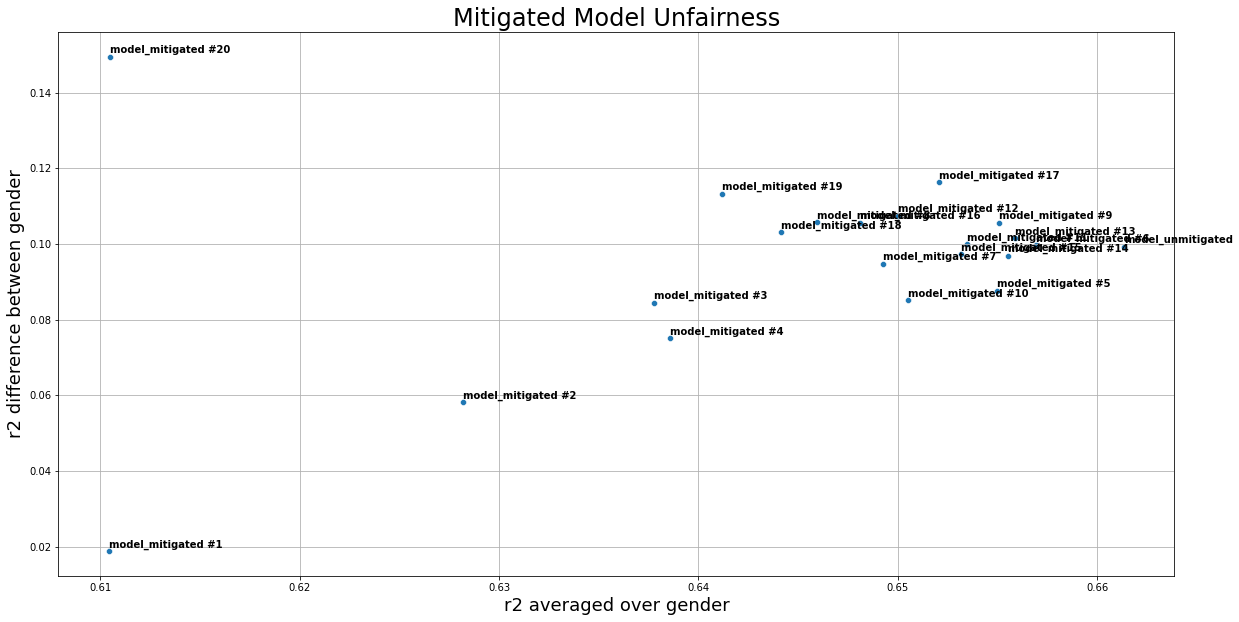

In [78]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='r2_group_average', 
                     y='r2_diff', 
                     data=df_fairness)

for line in range(0, df_fairness.shape[0]):
  ax.text(df_fairness.r2_group_average[line], df_fairness.r2_diff[line]+0.001, 
  df_fairness.index[line], horizontalalignment='left', 
  size='medium', color='black', weight='semibold')

ax.set_xlabel('r2 averaged over gender', size=18)
ax.set_ylabel('r2 difference between gender', size=18)
ax.set_title('Mitigated Model Unfairness', size=24)
ax.grid('on')

plt.show()

In [79]:
# Get predictions from all models them (plus the original unmitigated one for comparison)
model_name = 'clv_model_unmitigated'
print(model_name)
predictions = {model_name: tuned_model.predict(X_test)}
i = 0
for model in models:
    i += 1
    model_name = 'clv_model_mitigated_{0}'.format(i)
    print(model_name)
    predictions[model_name] = model.predict(X_test)

clv_model_unmitigated
clv_model_mitigated_1
clv_model_mitigated_2
clv_model_mitigated_3
clv_model_mitigated_4
clv_model_mitigated_5
clv_model_mitigated_6
clv_model_mitigated_7
clv_model_mitigated_8
clv_model_mitigated_9
clv_model_mitigated_10
clv_model_mitigated_11
clv_model_mitigated_12
clv_model_mitigated_13
clv_model_mitigated_14
clv_model_mitigated_15
clv_model_mitigated_16
clv_model_mitigated_17
clv_model_mitigated_18
clv_model_mitigated_19
clv_model_mitigated_20


In [80]:
#FairnessDashboard(sensitive_features=X_test[sensitive_features],
#                   y_true=y_test,
#                   y_pred=predictions)